# 3. Evaluación de un modelo OLS y supuestos a cumplir

In [1]:
import matplotlib.pyplot as plt #para gráficos
import statsmodels.api as sm #para modelos
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor #para calcular el VIF
import scipy.stats as stats #para calcular los residuos estandarizados
from sklearn.metrics import mean_squared_error #para calcular el MSE
import numpy as np

In [2]:
import matplotlib
import statsmodels
import scipy
import sklearn
import sys

# Function to get the version of JupyterLab
def get_jupyterlab_version():
    try:
        import jupyterlab
        return jupyterlab.__version__
    except ImportError:
        return 'Not Installed'
    
library_versions = {
    "python": sys.version,
    "jupyterlab": get_jupyterlab_version(),
    "pandas": pd.__version__,
    "numpy": np.__version__,
    "statsmodels": sm.__version__,
    "matplotlib": matplotlib.__version__,
    "sklearn": sklearn.__version__,  # Add this line
    "scipy": scipy.__version__,
}

library_versions

{'python': '3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]',
 'jupyterlab': '3.6.3',
 'pandas': '2.0.3',
 'numpy': '1.24.3',
 'statsmodels': '0.14.0',
 'matplotlib': '3.7.2',
 'sklearn': '1.3.0',
 'scipy': '1.11.1'}

## 3.1. Cargamos el modelo obtenido

In [2]:
mod_antiguo = sm.load('modelos/clases/modeloOLS_c1.pkl')

In [3]:
print(mod_antiguo.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     358.8
Date:                Wed, 13 Mar 2024   Prob (F-statistic):               0.00
Time:                        17:17:21   Log-Likelihood:                -16575.
No. Observations:                1399   AIC:                         3.317e+04
Df Residuals:                    1390   BIC:                         3.322e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -9.912e+05   1.38e+06     -0.719   

## 3.2. Capacidad de explicación e impacto de variables

### 3.2.1. Raíz del Error Cuadrático Medio (RMSE)

El RMSE es una medida de la diferencia promedio entre los valores reales y las predicciones del modelo, en la misma unidad que los datos originales. Cuanto menor sea el valor del RMSE, mejor será la capacidad predictiva del modelo.

Primero, importemos nuestros datos.

In [4]:
#Importo el archivo que usé
bdd_usada=pd.read_csv('data/clases/HousingPrices_Filtered_C1.csv')
bdd_usada.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1399 entries, 0 to 1398
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   YearBuilt     1399 non-null   int64
 1   2ndFlrSF      1399 non-null   int64
 2   GrLivArea     1399 non-null   int64
 3   FullBath      1399 non-null   int64
 4   HalfBath      1399 non-null   int64
 5   BedroomAbvGr  1399 non-null   int64
 6   TotRmsAbvGrd  1399 non-null   int64
 7   YrSold        1399 non-null   int64
 8   SalePrice     1399 non-null   int64
dtypes: int64(9)
memory usage: 98.5 KB


En el cuaderno anterior, si al guardar mi archivo filtrado no hubiera escrito `index=False`, ahora tendría una columna llamada `Unnamed: 0` en mi *dataframe*. Y tendríamos que ponernos a editar el *dataframe* para eliminarlo.

¿Qué creen que necesitamos para encontrar los errores? Si ya teníamos nuestro modelo con una constante y un coeficiente, sólo nos faltaría aplicarlo a nuestros valores reales del *dataframe* para compararlos.

Empecemos creando objetos para indicarle a Python cuáles son mis *X* y mis *Y*.

In [5]:
X=bdd_usada.drop(['SalePrice'],axis=1)
y=bdd_usada['SalePrice']

A mis *X* les añado una constante. Recuerden que nuestro modelo tiene una.

In [6]:
X = sm.add_constant(X) #es una función de la libería 'sm'

In [7]:
#Reviso que esté en orden
X

,const,YearBuilt,2ndFlrSF,GrLivArea,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,YrSold
0,1.0,2003,854,1710,2,1,3,8,2008
1,1.0,1976,0,1262,2,0,3,6,2007
2,1.0,2001,866,1786,2,1,3,6,2008
3,1.0,1915,756,1717,1,0,3,7,2006
4,1.0,2000,1053,2198,2,1,4,9,2008
...,...,...,...,...,...,...,...,...,...
1394,1.0,1999,694,1647,2,1,3,7,2007
1395,1.0,1978,0,2073,2,0,3,7,2010
1396,1.0,1941,1152,2340,2,0,4,9,2010
1397,1.0,1950,0,1078,1,0,2,5,2010


Ahora sí calculo el RMSE

In [8]:
# Hacer predicciones con el modelo
predicciones = mod_antiguo.predict(X)

# Calcular el MSE
mse = mean_squared_error(y, predicciones) #mean_squared_error ya es una función predefinida de 'sm'

#Ahora el RMSE
rmse = np.sqrt(mse) #usamos numpy (cargada como 'np' al inicio) para sacar la raíz cuadrada

#Le pido que me muestre cuál es el valor
rmse 

33821.01127443376

En este caso, podemos decir que **estamos alejados US$ 33.821 del valor real** de las viviendas de nuestros datos.

### 3.2.2. $R^2$

El $R^2$ es la medida estadística de **qué tan cerca están los datos de la línea de regresión**. También se conoce como coeficiente de determinación, mide cuánta varianza en la variable Y es explicada por todas nuestras X.

En términos sencillos, **qué porcentaje de Y nos permite explicar nuestro modelo**. Cuando estamos tratando de estimar o predecir un valor, es un valor importante.

En nuestro modelo, su valor es de 67.4%.

### 3.2.3. Los p-valores

Es lo que aparece en nuestra tabla como `P>|t|`. Se refiere a la significancia estadística de los coeficientes de las variables X. 

Dicho de otro modo, nos indican qué tan confiables son esos coeficientes, y, por tanto, esas variables. Se asume que **si su valor es menor a 0.05, el coeficiente es estadísticamente significativo**. Cuando se hacen modelos de precios hedónicos, se prefiere que sólo se tomen en cuenta variables que cumplen con esta característica.

En nuestro modelo, `FullBath`, `HalfBath`, `TotRmsAbvGrd` y `YrSold` no tienen coeficientes signifativos, por lo que no podemos 'confiar' en ellas.

## 3.3. Supuestos a cumplir

Más allá de qué tan bueno sea un modelo a partir de lo revisado en el apartado anterior, es necesario que estén muy seguros/as de que cumpla con algunos supuestos.

Como les comenté al inicio, hemos elaborado un modelo de regresión OLS. Este tipo de modelos requieren que se cumpla con lo siguiente:

### 3.3.1. Linealidad de los datos

Se espera una relación lineal $X$ e $y$. Esto es sencillo de ver a través de un gráfico de dispersión cuando tenemos una regresión lineal simple (una $X$ y una $y$), pero en el caso de una regresión lineal múltiple usualmente se utilizan los *gráficos de residuos*. Idealmente, en este gráfico no se va a observar ningún patrón claro de relación entre el eje vertical y horizontal. Si no fuese así, **se recomienda transformar las variables** ($\log(X)$, $\sqrt{X}$, $X^2$).

Esta transformación suele hacerse primero en la variable a estimar ($y$), y si aún así el modelo sigue presentando errores, se puede hacer en las variables independientes. Ten en cuenta que eso implicará una [interpretación distinta de los coeficientes del modelo](https://economipedia.com/definiciones/logaritmos-en-econometria.html).

### 3.3.2. Homosedasticidad

En términos sencillos, la homocedasticidad significa que la variabilidad de los errores (o residuos) de un modelo estadístico es constante en todas las posibles combinaciones de valores de las variables independientes.

Si estuviéramos construyendo un modelo de regresión para predecir el precio de pisos basado únicamente en su superficie, la homocedasticidad implicaría que, sin importar el tamaño de la casa, la variabilidad en los errores del modelo es constante. En otras palabras, los errores no se vuelven más grandes ni más pequeños a medida que cambia el tamaño de la casa.

Esto también se puede observar con el *gráfico de residuos*: si los residuos están distribuidos uniformemente alrededor de la línea horizontal en $y$=0, esto sugiere que la varianza de los errores es constante a lo largo de los valores ajustados.

Tengan en cuenta que la homosedasticidad (aquello que **sí buscamos**) es lo contrario de la heterosedasticidad.

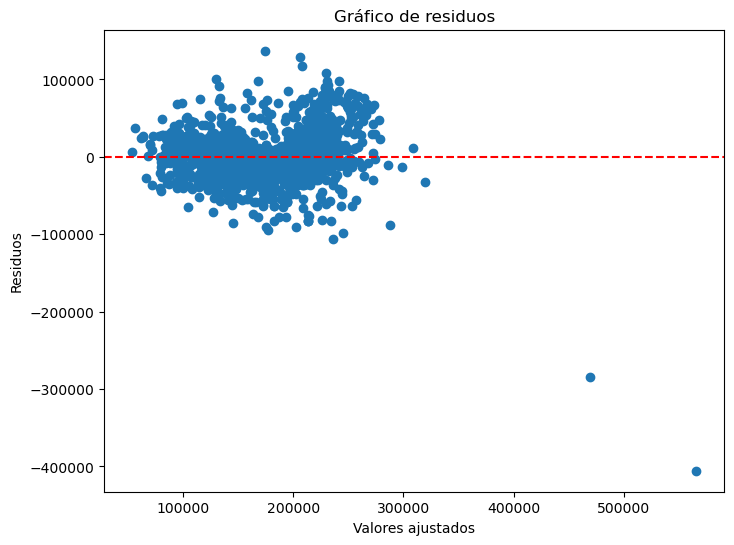

In [9]:
# Calcular los residuos del modelo
residuos = mod_antiguo.resid ## 'mod_antiguo' es como llamé a mi modelo al cargarlo ##

# Graficar los residuos
plt.figure(figsize=(8, 6))
plt.scatter(mod_antiguo.fittedvalues, residuos) ## revisa 'mod_antiguo' ##
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Gráfico de residuos')
plt.xlabel('Valores ajustados')
plt.ylabel('Residuos')
plt.show()

#### 3.3.2.1. Detección de outliers

Si bien los resultados del gráfico nos indican que tenemos linealidad en los datos y también cumplimos con el supuesto de homosedasticidad, notamos que existen dos outliers: aquellos que tienen un error menor de US$ -250.000. Si bien podríamos pensar que al ser sólo dos no tienen un gran impacto en nuestro modelo, sí "fastidian" nuestro error. Por tanto, idealmente deberíamos quitarlos y volver a correr el modelo.

In [17]:
#Noten que llamé 'residuos' al objeto que 
#contiene los residuos de mi modelo en la celda anterior 
residuos

0        -318.565692
1       17609.123625
2       10519.772420
3        4605.722838
4       11675.527163
            ...     
1455   -28003.273097
1456   -27857.770227
1457    66599.772302
1458    13136.979924
1459    -1975.460941
Length: 1399, dtype: float64

¡Noten para qué nos sirve el índice! Si ahora filtramos aquellos valores por debajo de US$ -250.000, podemos saber qué filas son los outliers.

In [11]:
outliers2= [(indice, valor) for 
            indice, valor in enumerate(residuos) ## revisar 'residuos' ##
            if valor < -250000]

outliers2

[(498, -284570.61729873205), (1241, -405574.82405305805)]

Revisamos el *dataframe* que usamos para el modelo. Ya lo habíamos cargado en los pasos anteriores de este cuaderno.

In [12]:
bdd_usada.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1399 entries, 0 to 1398
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   YearBuilt     1399 non-null   int64
 1   2ndFlrSF      1399 non-null   int64
 2   GrLivArea     1399 non-null   int64
 3   FullBath      1399 non-null   int64
 4   HalfBath      1399 non-null   int64
 5   BedroomAbvGr  1399 non-null   int64
 6   TotRmsAbvGrd  1399 non-null   int64
 7   YrSold        1399 non-null   int64
 8   SalePrice     1399 non-null   int64
dtypes: int64(9)
memory usage: 98.5 KB


Noten que tenemos 1399 filas, con un índice que va desde 0 a 1398. Quitemos de una vez esos dos outliers.

In [13]:
nueva_bdd = bdd_usada.drop([498,1241], axis=0) ## revisar 'nueva_bdd' ## 
                                               #axis 0 son filas
nueva_bdd.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1397 entries, 0 to 1398
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   YearBuilt     1397 non-null   int64
 1   2ndFlrSF      1397 non-null   int64
 2   GrLivArea     1397 non-null   int64
 3   FullBath      1397 non-null   int64
 4   HalfBath      1397 non-null   int64
 5   BedroomAbvGr  1397 non-null   int64
 6   TotRmsAbvGrd  1397 non-null   int64
 7   YrSold        1397 non-null   int64
 8   SalePrice     1397 non-null   int64
dtypes: int64(9)
memory usage: 109.1 KB


A partir de aquí podríamos guardar la nueva base de datos y volver a correr el modelo.

### 3.3.3. Normalidad de los errores

Suponer que los errores tienen una distribución normal ayuda a que el modelo se ajuste bien a los datos reales. Esto significa que los valores reales tienden a estar cerca de los valores predichos por el modelo en la mayoría de los casos.

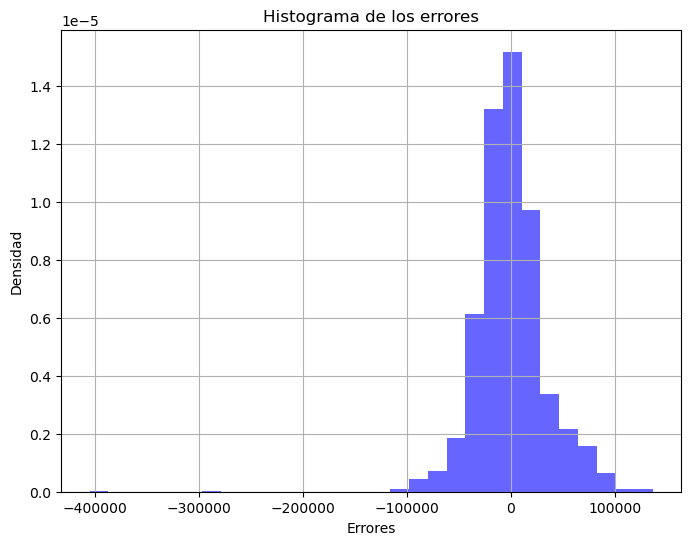

In [14]:
plt.figure(figsize=(8, 6))
plt.hist(residuos, ## revisar 'residuos' ## 
         bins=30, density=True, alpha=0.6, color='b')
plt.title('Histograma de los errores')
plt.xlabel('Errores')
plt.ylabel('Densidad')
plt.grid(True)
plt.show()

El gráfico nos muestra una distribución normal, pero con datos que lo distorsionan hacia la izquierda. ¿Adivinen cuáles son? Los outliers que encontramos hace un rato.

Usualmente, se suele complementar con la generación del siguiente gráfico:

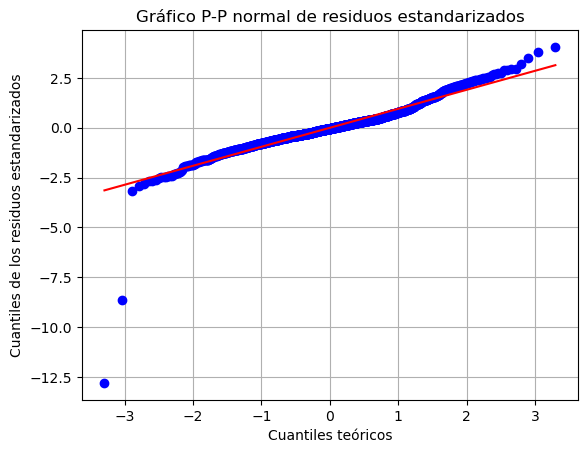

In [15]:
# Calcular los residuos estandarizados
residuos_estandarizados = mod_antiguo.get_influence().resid_studentized_internal ## revisar 'mod_antiguo' ##

# Calcular la distribución acumulativa de los residuos estandarizados
distribucion_acumulativa = stats.probplot(residuos_estandarizados, dist="norm", plot=plt)

# Personalizar el gráfico
plt.title('Gráfico P-P normal de residuos estandarizados')
plt.xlabel('Cuantiles teóricos')
plt.ylabel('Cuantiles de los residuos estandarizados')
plt.grid(True)
plt.show()

Si los puntos en el gráfico se aproximan a una línea diagonal, eso sugiere que los residuos siguen una distribución normal. Si hay desviaciones significativas de la línea diagonal, eso podría indicar que los residuos no siguen una distribución normal y podría requerir una investigación adicional.

### 3.3.4. Multicolinealidad

La presencia de multicolinealidad puede hacer difícil separar los efectos individuales de las variables colineales en la respuesta. Esto puede engañar tanto al modelo (influenciando en el p-valor de las variables) como a nosotros al momento de interpretar los resultados.

Nosotros ya hemos hecho un análisis de correlación y hemos visto que la mayoría de nuestras variables se relacionan significativamente entre ellas. Sin embargo, hay un punto hasta el que suele ser permitido ese nivel de correlación. Eso se mide a través del Factor de Inflación de la Varianza (VIF, por sus siglas en inglés). Si hay valores por encima de 3, se asume que esas variables no son recomendables de tomar en cuenta.

Ojo: este valor varía mucho entre investigaciones. Algunas consideran 3, otras 10, otras 40. Consulten bibliografía reciente sobre el tema que están tratando para tener un estándar (o consulten con Carlos).

In [16]:
#Al inicio de este cuaderno, importé todas mis X en una variable llamada 'X'

# Calcular el VIF para cada variable independiente
vif = pd.DataFrame()
vif["Variable"] = X.columns ## revisar 'X' ##
vif["VIF"] = [variance_inflation_factor(X.values, i) ## revisar 'X' ##
              for i in range(X.shape[1])] ## revisar 'X' ##

# Imprimir el resultado
print(vif)

       Variable           VIF
0         const  2.306952e+06
1     YearBuilt  1.768579e+00
2      2ndFlrSF  3.083363e+00
3     GrLivArea  4.184106e+00
4      FullBath  2.431363e+00
5      HalfBath  2.110762e+00
6  BedroomAbvGr  2.060995e+00
7  TotRmsAbvGrd  4.192325e+00
8        YrSold  1.002196e+00


Vemos que tanto `GrLivArea` como `TotRmsAbvGrd` tienen un VIF más alto de lo esperado, probablemente porque su correlación es muy alta. A partir de aquí pueden ir eliminando aquellas que les parecen menos relevantes, volver a correr un modelo y medir el VIF para ver si cumplen con un valor menor al esperado.

### 3.3.5. Autocorrelación de errores

De manera ideal, los errores de cada fila son independientes unos de otros. Cuando eso no sucede, hablamos de una autocorrelación de los errores o residuos del modelo. 

La autocorrelación es un fenómeno que se presenta en muestras que contengan de datos asociados al tiempo, aunque también puede presentarse cuando se trabaja con datos de corte transversal, usualmente cuando están georreferenciados (lo que se conoce como *autocorrelación espacial*).

Además, puede presentarse porque nuestra variable a estimar (*Y*) presenta un comportamiento cíclico que no viene explicado por las variables explicativas (*X*), si no que dicho comportamiento cíclico está recogido en el término de error del modelo. Esto nos habla de que nuestro modelo es malo: le falta algo, una variable que no hemos sido capaces de introducir en el modelo (¡y que no sabemos cuál es!).

Para medir esta autocorrelación de los errores, hay una medida llamada **Durbin-Watson**, que aparece en el resumen de nuestro modelo. **Si su valor está entre 1.5 y 2.5, se entiende que no existe una autocorrelación de los errores del modelo**.